In [4]:
import os
import shutil
from sklearn.model_selection import train_test_split
import shutil

data_dir = '/home/dmitrii/Desktop/hack_22_06_24_school_of_programming/data/classification_crop'

train_dir = os.path.join(data_dir, 'train')
val_dir = os.path.join(data_dir, 'val')

val_split = 0.2

shutil.rmtree(train_dir, ignore_errors=True)
shutil.rmtree(val_dir, ignore_errors=True)

os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

for class_name in os.listdir(data_dir):
    class_path = os.path.join(data_dir, class_name)
    if os.path.isdir(class_path) and class_name not in ['train', 'val']:
        images = [os.path.join(class_path, img) for img in os.listdir(class_path) if img.endswith(('.jpg', '.jpeg', '.png'))]

        if len(images) <= 5: continue

        train_images, val_images = train_test_split(images, test_size=val_split, random_state=42)

        train_class_dir = os.path.join(train_dir, class_name)
        val_class_dir = os.path.join(val_dir, class_name)
        os.makedirs(train_class_dir, exist_ok=True)
        os.makedirs(val_class_dir, exist_ok=True)

        for img in train_images:
            shutil.copy(img, os.path.join(train_class_dir, os.path.basename(img)))
        for img in val_images:
            shutil.copy(img, os.path.join(val_class_dir, os.path.basename(img)))

print("Разделение данных завершено.")

Разделение данных завершено.


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from sklearn.metrics import f1_score
import os

data_dir = '/home/dmitrii/Desktop/hack_22_06_24_school_of_programming/data/classification_crop'
batch_size = 16
num_epochs = 30
learning_rate = 0.0006
num_classes = len(os.listdir(os.path.join(data_dir, 'train')))  # Количество классов

# Трансформации для данных
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Загрузка данных
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
dataloaders = {x: DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

model = models.mobilenet_v3_large(pretrained=True)
model.classifier[3] = nn.Linear(model.classifier[3].in_features, num_classes)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=learning_rate)
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=learning_rate, steps_per_epoch=len(dataloaders['train']), epochs=num_epochs)


for epoch in range(num_epochs):
    print(f'Epoch {epoch}/{num_epochs - 1}')
    print('-' * 10)

    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()
        else:
            model.eval()

        running_loss = 0.0
        running_corrects = 0
        all_labels = []
        all_preds = []

        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()
                    scheduler.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]
        epoch_f1 = f1_score(all_labels, all_preds, average='weighted')

        print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} F1: {epoch_f1:.4f}')

Epoch 0/29
----------


/home/dmitrii/anaconda3/envs/venv_ilona/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/dmitrii/anaconda3/envs/venv_ilona/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


train Loss: 1.8617 Acc: 0.2753 F1: 0.2734
val Loss: 1.8312 Acc: 0.2845 F1: 0.2744
Epoch 1/29
----------
train Loss: 1.6561 Acc: 0.4251 F1: 0.3655
val Loss: 1.6143 Acc: 0.5345 F1: 0.4884
Epoch 2/29
----------
train Loss: 1.3047 Acc: 0.5529 F1: 0.4846
val Loss: 1.1341 Acc: 0.6121 F1: 0.5413
Epoch 3/29
----------
train Loss: 0.9080 Acc: 0.6520 F1: 0.6382
val Loss: 0.6820 Acc: 0.7500 F1: 0.7435
Epoch 4/29
----------
train Loss: 0.7489 Acc: 0.7048 F1: 0.6998
val Loss: 0.7589 Acc: 0.7241 F1: 0.7055
Epoch 5/29
----------
train Loss: 0.7558 Acc: 0.7159 F1: 0.7116
val Loss: 0.6505 Acc: 0.7155 F1: 0.7332
Epoch 6/29
----------
train Loss: 0.7298 Acc: 0.7181 F1: 0.7101
val Loss: 0.6899 Acc: 0.7500 F1: 0.7600
Epoch 7/29
----------
train Loss: 0.6405 Acc: 0.7423 F1: 0.7412
val Loss: 0.3749 Acc: 0.8621 F1: 0.8656
Epoch 8/29
----------
train Loss: 0.6385 Acc: 0.7687 F1: 0.7672
val Loss: 0.4595 Acc: 0.9052 F1: 0.9070
Epoch 9/29
----------
train Loss: 0.5401 Acc: 0.7996 F1: 0.7969
val Loss: 0.3418 Acc: 

In [2]:
class_names

['culture',
 'demographics',
 'dorogi',
 'ecology',
 'education',
 'healthcare',
 'urban_env']

In [3]:
torch.save(model.state_dict(), 'model.pt')

In [6]:
model

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bi

In [4]:
import onnxruntime as ort
import torchvision.transforms as transforms
from PIL import Image
import numpy as np

class CropClassificatorONNX:
    def __init__(self, model_path='classification_crop.onnx'):
        self.model = ort.InferenceSession(model_path)

        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
        ])

        self.class_names = [
            'culture',
            'demographics',
            'dorogi',
            'ecology',
            'education',
            'healthcare',
            'urban_env'
        ]
    
    def predict(self, image):
        image = self.transform(image).unsqueeze(0).numpy()

        inputs = {self.model.get_inputs()[0].name: image}
        outputs = self.model.run(None, inputs)
        outputs = outputs[0]

        if np.max(outputs) < 5:
            return 'None'

        predicted = np.argmax(outputs, axis=1)
        predicted_class = self.class_names[predicted.item()]

        return predicted_class
    

if __name__ == "__main__":
    classifier = CropClassificatorONNX(model_path='classification_crop.onnx')

    image = Image.open('1-1.jpg').convert('RGB')
    prediction = classifier.predict(image)

    print(f'Predicted class: {prediction}')


Predicted class: None


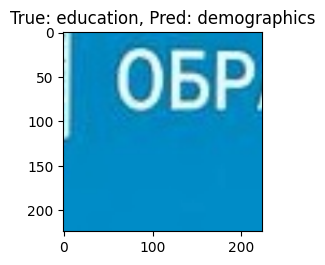

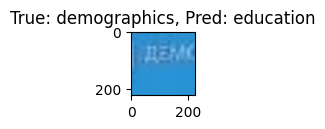

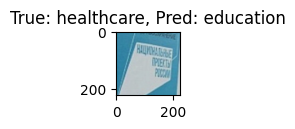

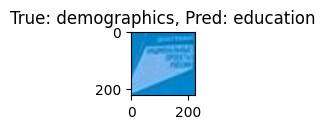

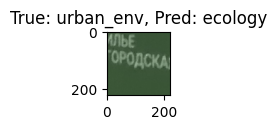

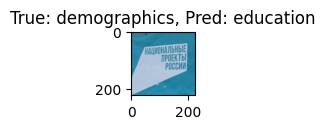

In [6]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)



incorrect_images = []
incorrect_labels = []
incorrect_preds = []

with torch.no_grad():
    for inputs, labels in dataloaders['val']:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        incorrects = (preds != labels).nonzero(as_tuple=True)[0]

        for i in incorrects:
            incorrect_images.append(inputs[i].cpu())
            incorrect_labels.append(labels[i].cpu())
            incorrect_preds.append(preds[i].cpu())

num_images = len(incorrect_images)
plt.figure(figsize=(15, 15))

for i in range(min(num_images, 25)):
    ax = plt.subplot(5, 5, i + 1)
    imshow(incorrect_images[i], title=f"True: {class_names[incorrect_labels[i]]}, Pred: {class_names[incorrect_preds[i]]}")
    ax.axis('off')

plt.show()

In [2]:
import torch
import torchvision.models as models
import torch.nn as nn

# Загрузка модели и весов
model = models.mobilenet_v3_large(pretrained=False)
model.classifier[3] = nn.Linear(model.classifier[3].in_features, 7)
model.load_state_dict(torch.load('classification_crop.pth'))

# Установка модели в режим оценки
model.eval()

# Пример входного тензора
dummy_input = torch.randn(1, 3, 224, 224)

# Экспорт модели в формат ONNX
torch.onnx.export(model, dummy_input, 'classification_crop.onnx', input_names=['input'], output_names=['output'])
